# 3. Set up Ubuntu VM on AWS EC2 for Remote GPU Training
We will use AWS EC2 to set up an instance of a remote Linux virtual machine (VM) which we will SSH into to train our model. This will save us considerable time in training as we will have access to a CUDA enabled Tesla T4 GPU. AWS was chosen because it is one of the most popular cloud computing platforms and it offers competitive pricing for GPU instances. Here I will guide you through the process of setting up an AWS EC2 instance.

## 3.1. Create or Sign in to AWS account
Visit the AWS webpage and click on ‘Sign In to the Console’. If you do not have an account, Sign up for AWS first.

Next, enter your credentials if you are signing in, or e-mail, account name and password if you need to sign up. If you are signing up you will also need to set your card payment details. This will be the card to which all the charges of the instance usage will be applied. You will also need to provide a phone number that will be called to verify your identity.

## 3.2. Request a service quota increase
We will be using a `g4dn.xlarge` which is a GPU instance. By default, AWS limits on demand G and VT instances to 0. To increase this limit you will need to request a service quota increase. To do this, first make sure you are in the correct region (top right next to your account name). Mine is London (eu-west-2). 

Then go to the AWS Service Quotas dashboard and click on 'Amazon Elastic Compute Cloud (Amazon EC2)'. From here search for and click on 'Running On-Demand G and VT instances'. On this page click 'Request increase at account level'. You'll be asked to enter a new limit in the 'Increase quota value' form. Enter 1 and click 'Request'.

Service quota increases can take anywhere from a few hours to a few days to be approved. You will receive an e-mail when your request has been approved. In the meantime, you can continue with the rest of the steps.

## 3.3. Create a key pair
For this step, you’ll need a terminal. If you're on Windows I strongly recommend using WSL, which can be installed by following [these steps](https://learn.microsoft.com/en-us/windows/wsl/install). This will allow you to use a Linux terminal on Windows and makes SSHing into the remote VM much easier. 

Once in your terminal, type ‘ssh-keygen’ then press return three times. This will create a directory named .ssh/ with two files in it, ‘id_rsa’ and ‘id_rsa.pub’. The first one is your private key and you should keep it safe, the second one is your public key and you will need to copy it to your AWS account. To do this, type the following command in your terminal. Replace `<your_username>` with your username and `<your_directory>` with the directory you want to copy the public key to.

```bash
cp .ssh/id_rsa.pub /mnt/c/Users/<your_username>/<your_directory>
```

Next, go to the AWS EC2 dashboard and click on ‘Key Pairs’ under ‘Network & Security’ on the left-hand side. Click on the 'Actions' dropdown menu and select 'Import Key Pair', give it a name, I called mine 'id_rsa', and browse for the public key file you just copied to your directory. Click 'Import key pair' and you should see your key pair in the list.

## 3.4 Create and launch an instance
Once the service quota increase has been approved, go to the AWS EC2 dashboard and click on ‘Launch Instance’. Set up the instance as follows:

- Step 1: Give the instance a name, I called mine 'deep-learning'
- Step 2: Select the 'Ubuntu Server 22.04 LTS (HVM), SSD Volume Type' AMI
- Step 3: Select the 'g4dn.xlarge' instance type
- Step 4: Choose your Key pair name from the previous step
- Step 5: Increase the storage size to 50GB (you get 30GB free with the free tier in your first year)

You can leave the rest of the settings as default and then click 'Launch'. 

## 3.5. Initial SSH into the instance
From the dashboard, click on 'Instances' from the sidebar on the left. You should see your instance in the list. Select it and from the 'Instance state' dropdown click 'Start instance'. It will take a few moments for the instance to full start up, once it has copy the Public IPv4 address, `<public-IP>`. You will need this to SSH into the instance.

Open a terminal and type the following command:

```bash
ssh ubuntu@<your-IP>
```
If prompted, type 'yes' to continue connecting. You should now be logged into your remote VM, in the next section we will set up the VM server and install the necessary depencies using a virtual environment with Anaconda and mamba.

## 3.6 Set up Ubuntu server, install dependencies and SSH tunneling
We will use fastai's [fastsetup](https://github.com/fastai/fastsetup) repository which contrains bash scripts to quickly set up an Ubuntu server with all the necessary dependencies for deep learning. The following steps will guide you through the process of setting up the VM server and installing the dependencies.

The following commands will install Git, clone the [fastsetup](https://github.com/fastai/fastsetup) repository and run the setup script. The setup script will run you through securing and configuring Ubuntu:

```bash
sudo apt update && sudo apt -y install git
git clone https://github.com/fastai/fastsetup.git
cd fastsetup
sudo ./ubuntu-initial.sh
```

When prompted for a hostname, enter something recognisable. I chose 'aws-gpu.example.com', you can choose anything you like but it must have two periods and be in the format of `<name>.<domain>.<tld>`. When prompted for an email address, enter a valid email address you have access to. And set a password when prompted, you'll need this to run `sudo` commands.

Rebooted when prompted and SSH back into the instance but this time using SSH tunneling. This will allow us to access the Jupyter Notebook running on the remote VM from our local machine. To do this, open a new terminal and type the following command:

```bash
ssh -L localhost:8888:localhost:8888 ubuntu@<your-IP>
```

If you get an error saying ```channel 3: open failed: connect failed: Connection refused``` try the following instead, or try changing the port number from `8888` to something else like `8783` or `8787`. 

```bash
ssh -v -L 8888:127.0.0.1:8888 ubuntu@<your-IP>
```

Install miniconda and mamba using the following commands:

```bash
cd fastsetup
./setup-conda.sh
source ~/.bashrc
conda install -yq mamba
```

Create a new conda environment and install the necessary dependencies and NVIDIA drivers using the following commands:

```bash
mamba create -n <your-env-name> python=3.10
mamba init
mamba activate <your-env-name>
```

With the new environment activated, Find and install the NVIDIA drivers using the following commands. First find the drivers using the following command:

```bash
ubuntu-drivers devices
```

Install the driver with 'recommended' in the name and replace `<server-number>` with the number retruned by the previous command:

```bash
sudo apt-fast install -y nvidia-driver-<server-number>-server
nvidia-smi
```

You should see the NVIDIA driver version and GPU information. Finally we will install PyTorch first with CUDA support and then fastai using pip. Then we'll install jupyter using mamba:

```bash
pip3 install torch torchvision torchaudio
pip install fastai
pip install tabulate==0.9.0
mamba install -yq jupyter
```

We can clone the repository containing the preprocessed data and open the training notebook using the following commands:

```bash
cd
git clone https://github.com/imharrisonking/rooftop-segmentation.git
cd rooftop-segmentation
jupyter notebook
```

This will open a Jupyter Notebook in your browser and you can open and run the training notebook from here. Alternatively, if you are using VS Code you can connect to the remote Jupyter server by following [these steps](https://code.visualstudio.com/docs/datascience/jupyter-notebooks#_connect-to-a-remote-jupyter-server). Your termnial should output where the Jupyter Server is running, copy and paste this as your URL to the Jupyter Server in VS Code.

These steps were adapted from [fastai's Full Linux Server guide](https://course20.fast.ai/start_aws), but updated and added to for 2023 this guide was written in 2020.

# 4. Train the U-Net segmentation model

Our goal is to train a U-Net model to segment building footprints from drone imagery. We will use [`fastai`](https://docs.fast.ai/) built on top of [`PyTorch`](https://pytorch.org/docs/stable/index.html) to train our model as our deep learning framework.

Using the [Data Block API](https://docs.fast.ai/data.block.html) we will create a Dataloader object that will contain our training and validation data. 

We will perform image augmentation to each batch we pass through our model to improve the generalisation of our model. Using Transfer Learning with progressive resizing we will use a pre-trained ResNet34 to reduce the total number of epochs needed to train our model. 

Using the state of the art [Ranger Optimiser](https://lessw.medium.com/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d) which is a combination of the RAdam and LookAhead optimisers we will train our model. We will make use of fastai's [Learning Rate Finder](https://docs.fast.ai/callback.schedule.html#Learner.lr_find) to find the optimal learning rate for our model.

We'll define a custom function for the loss which will be a cobination of the [Dice Loss](https://docs.fast.ai/layers.html#CrossEntropyLossFlat) and [Cross Entropy Loss](https://docs.fast.ai/layers.html#CrossEntropyLossFlat) as our loss function as this has been shown to improve the performance of segmentation models.

Finally we'll check inference on a few images to see how well our model performs. We'll also look at the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) see if we need to add weights to our loss function to put less emphasis on the background `Void` class.

This section of the notebook is based around the [fastai Image Segmenation with CAMVID tutorial](https://docs.fast.ai/examples/camvid.html) and the [walkwithfastai Image Segmentation tutorial](https://walkwithfastai.com/Segmentation#The-Dynamic-Unet).

## 4.1. Import libraries, check CUDA and set up paths

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tabulate

from fastcore.xtras import Path
from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos
from fastai.data.block import DataBlock
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize
from fastai.layers import Mish
from fastai.losses import DiceLoss, FocalLossFlat, store_attr
from fastai.optimizer import ranger
from fastai.torch_core import tensor
from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask, Image
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner
from fastai.metrics import DiceMulti, JaccardMulti, accuracy_multi

from torch import nn
from torchvision.models.resnet import resnet34
import torch
import torch.nn.functional as F

In [ ]:
# Check the Linux distribution, GPU model and CUDA version
!lsb_release -a
!nvidia-smi

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy


Wed Nov 29 08:58:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1E.0 Off |                    0 |
| N/A   38C    P0              24W /  70W |      2MiB / 15360MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Check the installed packages
!mamba list

# packages in environment at /home/ubuntu/mambaforge/envs/geo:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
annotated-types           0.6.0                    pypi_0    pypi
anyio                     4.1.0              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py310h2372a71_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.1.0             pyh71513ae_1    conda-forge
babel                     2.13.1             pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.12.2             pyha770c72_0    conda-forge

In [4]:
# Check that CUDA is available
torch.cuda.is_available()

True

In [2]:
TILE_SIZE = 256
ZOOM_LEVEL = 19

path = Path('./data')
for file in path.iterdir():
    print(file)

FileNotFoundError: [Errno 2] No such file or directory: 'data'

In [3]:
# Get the path to the images and masks
path_images = path/'images'/f's{TILE_SIZE}_z{ZOOM_LEVEL}'
path_masks = path/'masks'/f's{TILE_SIZE}_z{ZOOM_LEVEL}'

# Get filenames for the training images and masks
file_names = get_image_files(path_images/'train')
label_names = get_image_files(path_masks/'train')

# Get filenames for the validation images and masks
file_names_validation = get_image_files(path_images/'validation')
label_names_validation = get_image_files(path_masks/'validation')

print('Training images:', len(file_names))
print('Training masks:', len(label_names))

Training images: 328
Training masks: 328


Let's define a function `get_image_mask` to get the image and mask paths for each image in our dataset. We'll use this function to create a `DataBlock` object which will contain our training and validation data.

In [4]:
def get_image_mask(image_path: Path) -> Path:
    ''' Gets the path of the mask corresponding to the image path
    Args:
        image_path (Path): Path to the image

    Returns:
        Path: Path to the mask
    '''
    return path_masks/image_path.parent.name/f'{image_path.stem}_mask.png'

In [5]:
print('Example image: ', file_names[0])
print('Example mask: ', get_image_mask(file_names[0]))

Example image:  data\images\s256_z19\train\319377_270493_19.png
Example mask:  data\masks\s256_z19\train\319377_270493_19_mask.png


Test opening an image and mask to make sure the paths are correct and our function works as expected. We'll plot these to make sure they are the correct images and masks.

<AxesSubplot:title={'center':'Image with mask'}>

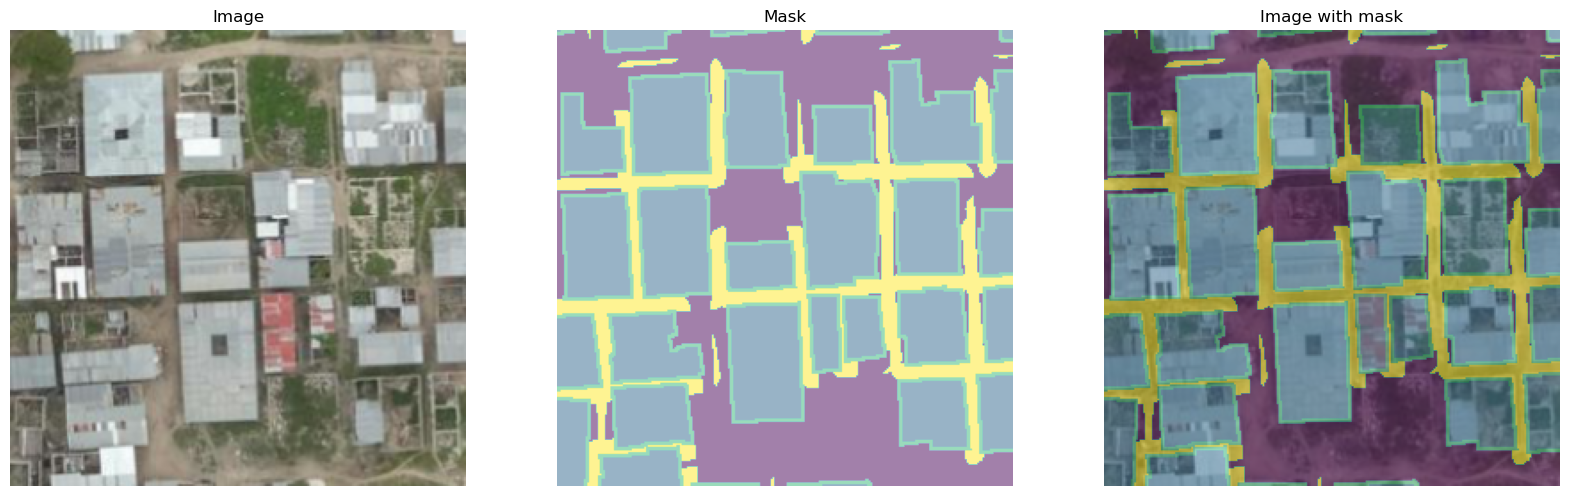

In [6]:
# Test opening an image and its mask
image_filename = file_names[10]
image = PILImage.create(image_filename)

mask = mask = PILMask.create(get_image_mask(image_filename))

# Show the image and mask side by side and overlay the mask on the image
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].set_title('Image')
image.show(ax=ax[0])

ax[1].set_title('Mask')
mask.show(ax=ax[1], cmap='viridis')

ax[2].set_title('Image with mask')
image.show(ax=ax[2])
mask.show(ax=ax[2], cmap='viridis', alpha=0.5)

## 4.2 Find class imbalances in the training data
From looking at the masks we see that there is a class imbalance in our dataset. There are far more pixels in the `Void` class than in the `Building` class. We can then use weights in the Focal Loss function to put less emphasis on the `Void` class. First let's get a feel for this class imbalance by plotting the percentage of pixels in each class across all of the masks in our training set.

In [45]:
# Classes for each channel in the mask
classes = ['Void', 'Footprint', 'Boundary', 'Contact']

# Turn this into a dictionary mapping from class to index
class_count = {0: 0, 1: 0, 2: 0, 3: 0}

+-----------+----------------------------+
| Class     |   Percentage of pixels (%) |
|-----------+----------------------------|
| Void      |                      78.79 |
| Footprint |                      15.05 |
| Boundary  |                       3.84 |
| Contact   |                       2.32 |
+-----------+----------------------------+


Text(0, 0.5, 'Percentage of pixels (%)')

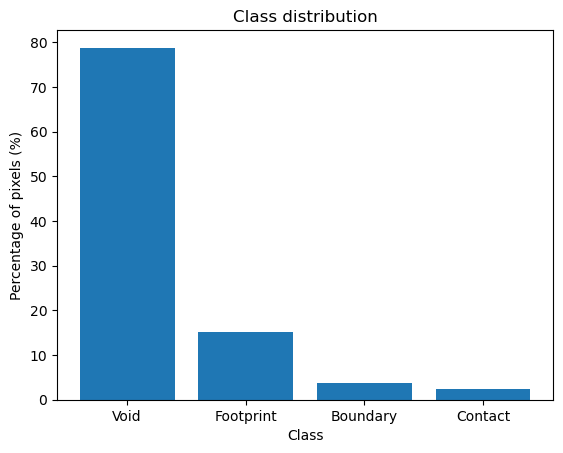

In [44]:
# Loop through all the masks and count the number of pixels for each class
for mask_path in label_names:
    mask = PILMask.create(mask_path)
    mask_array = np.array(mask)
    unique, counts = np.unique(mask_array, return_counts=True)
    for i, count in enumerate(counts):
        class_count[i] += count

# Calculate the percentage of pixels for each class
class_percent = {k: v / sum(class_count.values()) for k, v in class_count.items()}
class_percent_values = np.array(list(class_percent.values()))*100

print(tabulate.tabulate(zip(classes, class_percent_values), headers=['Class', 'Percentage of pixels (%)'], tablefmt='psql', floatfmt=('.0f', '.2f')))

# Plot the number of pixels for each class
plt.bar(classes, class_percent_values)
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Percentage of pixels (%)')

In [46]:
# Create a weights tensor to be used later in the loss function
weights = tensor([1 - class_percent[i] for i in range(len(classes))]).cuda()
weights

tensor([0.2121, 0.8495, 0.9616, 0.9768])

##  4.2 Transfer Learning from ResNet34 using progressive resizing
Start off training on smaller images and then gradually increase the size of the images as the training progresses. This is called progressive resizing. This technique is used to train models faster and with higher accuracy.

On the first run we will train the model on images half the size (128x128) of the original images (256x256). We will then increase the size of the images to their original size (256x256) and train the model again.

Batch transforms are applied to all images in dataloaders and fall under two catergories:
- Augmentations: These are transformations that change the image in some way. For example, resizing the image, flipping the image horizontally or rotating the image. Augmentations are used to increase the size of the training set and improve the generalisation of the model.
- Normalisations: These are transformations that change the pixel values of the image this is usually done to standardise the input data, aiding in model training stability and speed.

The `aug_transforms` function will allow us to do the progressive resizing technique and generalise the model as mentioned above. to apply to each batch we pass through the model. `Normalize.from_stats(*imagenet_stats)` applies normalization to our new data using the mean and standard deviation of the ImageNet dataset which is the dataset that ResNet34 was trained on. This will make our Transfer Learning more effective.

We will re-use the list of `classes` as the codes for our model to predict, we will pass this to the `MaskBlock` class on intialisation and the `dataloader` object for it's `vocab` attribute for making predictions. The `class_mapping` dictionary maps the class names to their corresponding integer values the same way the dataloader will read it.

We won't use any item transforms as all of our images are the same size and we don't need to resize them individually. 

In [47]:
class_mapping = {'Void': 0, 'Footprint': 1, 'Boundary': 2, 'Contact': 3}

In [11]:
# Define the image size and batch size
size = int(TILE_SIZE / 2)
batch_size = 16

# Define the data augmentation transforms to apply to the images and masks
batch_transforms = aug_transforms(flip_vert=True, max_warp=0.1, max_rotate=30, max_zoom=2, max_lighting=0.2, size=size)

# Define the data block
buildings = DataBlock(blocks=(ImageBlock, MaskBlock(codes=classes)),
                       get_items=get_image_files,
                       splitter=FuncSplitter(lambda o: o.parent.name == 'validation'),
                       get_y=get_image_mask,
                       batch_tfms=[*batch_transforms, Normalize.from_stats(*imagenet_stats)])

A `dataloader` object is created by calling the `dataloaders` method on the `DataBlock` object. We will pass in the path to our training images and the batch size defined above. Once created we can call the `show_batch` method to see a batch of images and their corresponding masks overlayed.

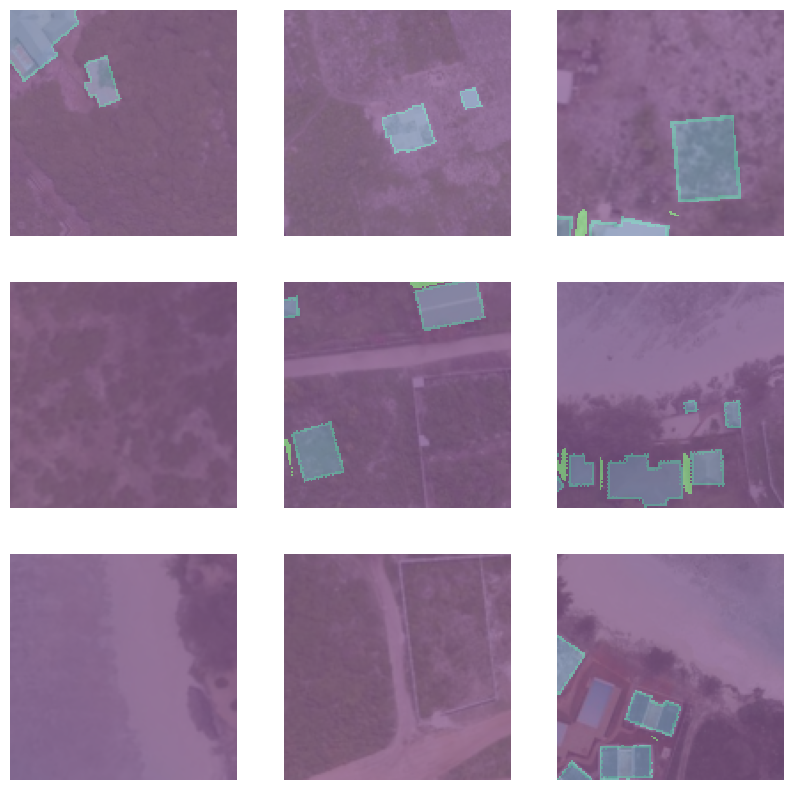

In [12]:
dataloders = buildings.dataloaders(path_images, bs=batch_size)

# Show a batch of images and masks
dataloders.show_batch(max_n=9, figsize=(10, 10), alpha=0.5, cmap='viridis')

In [13]:
# Make our vocabulary a part of the dataloaders, loss function needs to deal with the Void label
dataloders.vocab = classes

## 4.3 Set up a Dynamic U-Net model
We will fastai's Dynamic U-Net model architecture to train our segmentation model. The U-Net model architecture was first introduced in the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) by Olaf Ronneberger, Philipp Fischer, and Thomas Brox. The U-Net model architecture is a convolutional neural network (CNN) that was originally designed for biomedical image segmentation.

U-Net allows us to look at pixel-wise representations of our images through the use of a contracting path and an expansive path. The contracting path is a typical CNN that consists of convolutional and pooling layers. The expansive path is a series of up-convolutional layers that allow us to increase the resolution of the image. The expansive path is also known as the decoder and the contracting path is known as the encoder.

In Layman's terms this architecture takes in a large image as input, scales it down to a small image and then scales it back up to a large image.

`unet_learner` from `fastai.vision.learner` is a factory method that creates a `Learner` object with a U-Net model architecture. We can pass in model configurations to the factory method where we can customise the model.
- `dls` is the `DataLoaders` object we created that contains our training and validation data
- `arch` is the U-Net model architecture we want to use, we will use resnet34 as the encoder
- `metrics` is the metric we want to use to evaluate our model, we will use the `Dice` metric
- `loss_func` is the loss function we want to use to train our model, will use a combination of [`Dice Loss`](https://docs.fast.ai/losses.html#diceloss) and [`Focal Loss`](https://docs.fast.ai/losses.html#focalloss)
- `opt_func` is the optimizer we want to use to train our model, we will use the state of the art `Ranger` optimiser
- `self_attention` is a boolean value that determines whether we want to use self-attention layers in our model, we will set it to `True`
- `act_cls` is the activation function we want to use in our model, we will use the `Mish` activation function
- `blur` is a boolean value that determines whether we want to use blur pooling in our model, this can help with checkerboard artifacts in the output of the model, we may use this later

We need to create an accuracy function `accuracy_metric` which will be used to evaluate our model. For segmentation we will squeeze all of the outputted values to have a matrix of digits for our segmenation mask. Then we will compare the argmax of the outputted values to the target mask for each pixel and take the average. We will ignore the `Void` class when calculating the accuracy as this is the background class and we are more interested in the accuracy of the building footprint, boundary and contact classes.

In [14]:
def accuracy_metric(input, target):
    ''' Calculates the accuracy of the model by ignoring the Void class and comparing the argmax of the input with the target
    Args:
        input (Tensor): Predictions from the model
        target (Tensor): Ground truth labels

    Returns:
        float: Accuracy of the model
    '''
    target = target.squeeze(1)
    mask = target != class_mapping['Void']
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [15]:
# Define a custom loss function combining Focal Loss and Dice Loss
class DiceFocalLoss:
    '''Combines Flat Focal Loss and Dice Loss'''
    def __init__(self, axis=1, smooth=1e-06, gamma=1.0):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis, gamma=gamma, reduction='mean')
        self.dice_loss =  DiceLoss(axis, smooth, reduction='mean')

    def __call__(self, prediction, target):
        return self.focal_loss(prediction, target) * \
                self.dice_loss(prediction, target)

    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [48]:
# Use the weights tensor to pass to the Focal Loss constructor
weights

tensor([0.2121, 0.8495, 0.9616, 0.9768])

In [16]:
# Define our loss, optimiser and metrics to be passed to the learner
loss = FocalLossFlat(axis=1, gamma=2.0, weights=weights, reduction='mean')
optimiser = ranger
metrics = [accuracy_metric]

In [17]:
# Define the model
learn = unet_learner(dls=dataloders, arch=resnet34, loss_func=loss, opt_func=optimiser,
                     metrics=metrics, self_attention=True, act_cls=Mish)

# Show the model summary
learn.summary()

DynamicUnet (Input shape: 16 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 64 x 64   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 32 x 32   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

Let's find the optimal learning rate, we can use `learn.lr_find()` to find the optimal learning rate, the learning rate finder can find the optimal learning rate using one of four methods:
- Minimum
- Steep
- Valley
- Slide

As suggested in [this forum post](https://forums.fast.ai/t/new-lr-finder-output/89236/2) we will use the default valley method as our optimal learning rate.

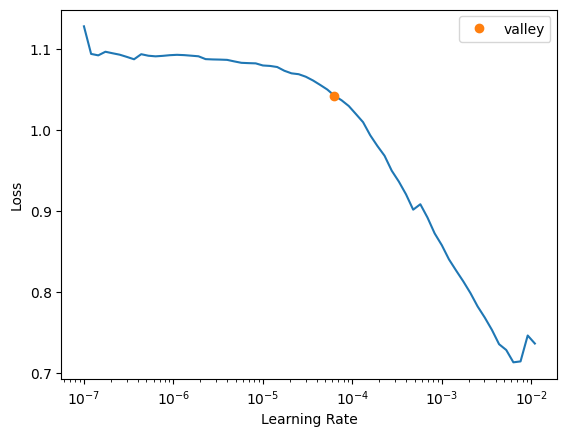

In [18]:
learning_rate = learn.lr_find()

In [19]:
learning_rate = learning_rate.valley
print('Learning rate:', learning_rate)

Learning rate: 6.30957365501672e-05


## 4.3 Train the model frozen
We'll train the model initially for 10 epochs and using `slice(learning_rate)` we will allow the learning rate to change during training.

Notice that the `train_loss` and `valid_loss` both decrease with each epoch. This is a good sign that our model is learning and not overfitting.

In [20]:
# Train the model for 10 epochs using fit flat cosine
learn.fit_flat_cos(10, slice(learning_rate))

epoch,train_loss,valid_loss,accuracy_metric,time
0,0.976231,0.787954,0.071942,00:05
1,0.733739,0.449232,0.287893,00:05
2,0.548254,0.345409,0.277474,00:05
3,0.438516,0.311498,0.482049,00:05
4,0.368927,0.264068,0.367761,00:05
5,0.319146,0.257911,0.508011,00:05
6,0.281619,0.248225,0.542386,00:05
7,0.253265,0.217340,0.492107,00:05
8,0.233235,0.216106,0.527203,00:05
9,0.219368,0.211484,0.505266,00:05


Save the inital model and show the results of target against prediction for a batch of images.

In [21]:
learn.save('stage-1')
learn.load('stage-1')

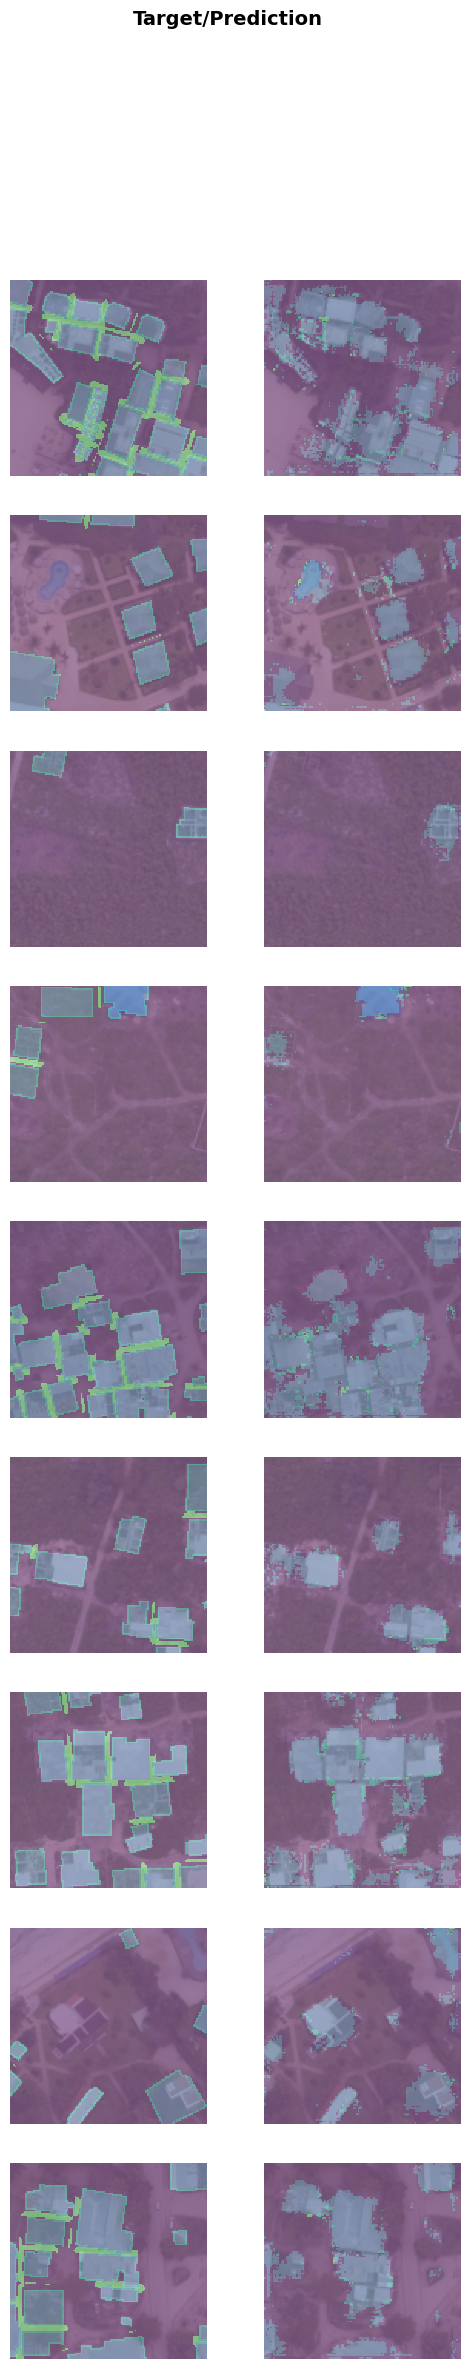

In [23]:
learn.show_results(max_n=9, alpha=0.5, cmap='viridis')

## 4.4 Unfreeze the model, decrease the learning rate and train again
Next we will unfreeze the model and decrease the learning rate by a factor of 4

In [24]:
decreased_lrs = slice(learning_rate/400, learning_rate/4)
learn.unfreeze()
learn.fit_flat_cos(10, decreased_lrs)

epoch,train_loss,valid_loss,accuracy_metric,time
0,0.192922,0.213235,0.523816,00:05
1,0.194248,0.210320,0.527112,00:05
2,0.188176,0.207503,0.506303,00:05
3,0.186018,0.210230,0.553366,00:05
4,0.185620,0.207901,0.559839,00:05
5,0.184938,0.204981,0.556609,00:05
6,0.183860,0.199755,0.557075,00:05
7,0.181012,0.194441,0.523752,00:05
8,0.179735,0.192625,0.541495,00:05
9,0.177599,0.195402,0.560127,00:05


In [25]:
# Save this initial model training
learn.save('model_1')

Path('models/model_1.pth')

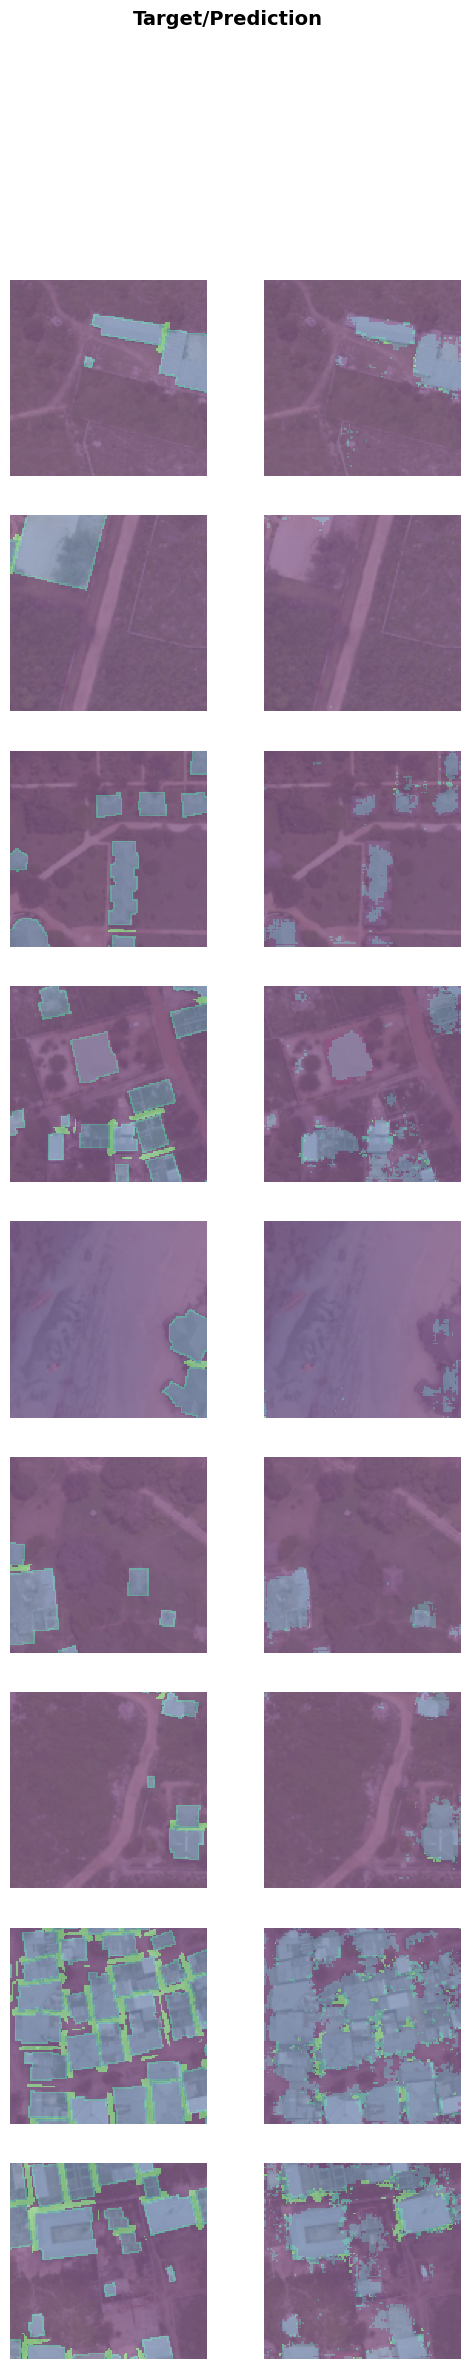

In [27]:
# Look at a few results
learn.show_results(max_n=9, alpha=0.5, cmap='viridis')

## 4.5 Full sized image training
We will now train the model on the full sized images. We will use the same model configurations as before but we will change the batch size to 1 and the image size to 256x256.

First let's re-create our `DataLoaders` object with the new batch size and image size. We will also need to create a new `Learner` object with the new `DataLoaders` object.

In [29]:
# Full size image and lower batch size to save memory
size = TILE_SIZE
batch_size = 1

# Define the data augmentation transforms to apply to the images and masks
batch_transforms = aug_transforms(flip_vert=True, max_warp=0.1, max_rotate=30, max_zoom=2, max_lighting=0.2, size=size)

# Define the data block
buildings = DataBlock(blocks=(ImageBlock, MaskBlock(codes=classes)),
                       get_items=get_image_files,
                       splitter=FuncSplitter(lambda o: o.parent.name == 'validation'),
                       get_y=get_image_mask,
                       batch_tfms=[*batch_transforms, Normalize.from_stats(*imagenet_stats)])

dataloders = buildings.dataloaders(path_images, bs=batch_size)

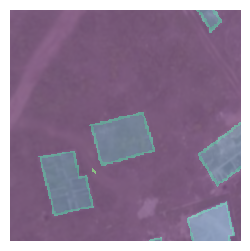

In [31]:
# Show a batch of images and masks
dataloders.show_batch(alpha=0.5, cmap='viridis')

In [32]:
# Set the vocabulary, create the learner and load the previous model
dataloders.vocab = classes
learn = unet_learner(dls=dataloders, arch=resnet34, loss_func=loss, opt_func=optimiser,
                     metrics=metrics, self_attention=True, act_cls=Mish)
learn.load('model_1')

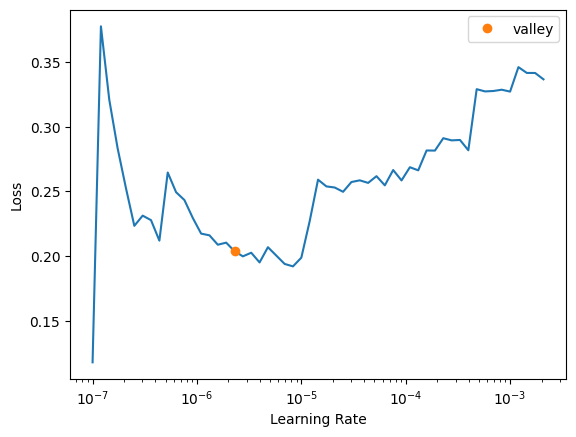

In [33]:
# Find the new learning rate
learning_rate = learn.lr_find()

In [34]:
learning_rate = learning_rate.valley
print('Learning rate:', learning_rate)

Learning rate: 2.2908675418875646e-06


In [35]:
learn.fit_flat_cos(10, slice(learning_rate))

epoch,train_loss,valid_loss,accuracy_metric,time
0,0.222671,0.172067,0.515619,00:32
1,0.222217,0.169357,0.548136,00:32
2,0.196588,0.167356,0.531653,00:32
3,0.234027,0.162689,0.499744,00:32
4,0.205030,0.170520,0.593377,00:32
5,0.206889,0.177581,0.591328,00:32
6,0.207515,0.180170,0.618677,00:32
7,0.196890,0.177499,0.613786,00:32
8,0.195091,0.158796,0.588190,00:32
9,0.201467,0.168891,0.592307,00:32


In [37]:
learn.save('stage-2')
learn.load('stage-2')

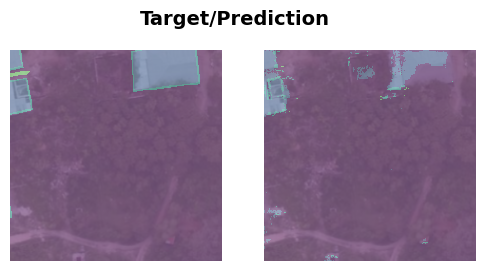

In [42]:
learn.show_results(max_n=9, alpha=0.5, cmap='viridis')

In [43]:
# Unfreeze the model, decrease the learning rate and train for 10 epochs
learn.unfreeze()

decreased_lrs = slice(learning_rate/400, learning_rate/4)
learn.fit_flat_cos(10, decreased_lrs)

epoch,train_loss,valid_loss,accuracy_metric,time
0,0.188756,0.182845,0.644795,00:36
1,0.214741,0.168259,0.608677,00:36
2,0.184630,0.168829,0.596276,00:36
3,0.210129,0.157626,0.581945,00:36
4,0.187180,0.158707,0.584662,00:36
5,0.208320,0.160486,0.587222,00:36
6,0.204744,0.157551,0.577364,00:36
7,0.188643,0.181546,0.634021,00:36
8,0.184186,0.166424,0.590227,00:36
9,0.202324,0.164368,0.610926,00:36


In [45]:
learn.save('full_model')

Path('models/full_model.pth')

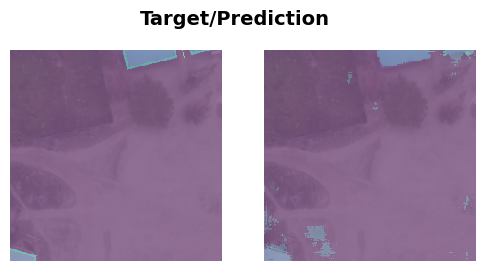

In [49]:
learn.show_results(max_n=9, alpha=0.5, cmap='viridis')

# 5 Inference
Using the GPU we can use `test_dl` to make batch predictions on our validation set. Let's just look at the first 9 images.

Eventually we'll define new file paths for inference images and predictions. For now we'll just use the first 9 images in the validation set.

In [38]:
DATA_DIR = Path('./data')
DATA_DIR.mkdir(exist_ok=True)

# Subdirectory for tile size (s) and zoom level (z)
IMAGE_PATH = DATA_DIR / 'images'
IMAGE_PATH.mkdir(exist_ok=True)

MASKS_PATH = DATA_DIR / 'masks'
MASKS_PATH.mkdir(exist_ok=True)

# Create predictions subdirectories at the same level as the training images and masks
PREDICTIONS_IMAGE_PATH = IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'predictions'
PREDICTIONS_IMAGE_PATH.mkdir(exist_ok=True)

PREDICTIONS_MASKS_PATH = MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'predictions'
PREDICTIONS_MASKS_PATH.mkdir(exist_ok=True)

In [ ]:
inference_dataloader = learn.dls.test_dl(file_names_validation[:9])
inference_dataloader.show_batch(max_n=9)

In [ ]:
predictions = learn.get_preds(dl=inference_dataloader)

In [ ]:
predictions[0].shape

The shape of the predictions is `(batch_size, classes, height, width)`. As we have a batch_size of 9 and 4 classes our predictions have a shape of `(9, 4, 128, 128)`. Let's take a closer look at the first prediction mask

In [ ]:
first_prediction = predictions[0][0]
first_prediction.shape

We can take the argmax of the predictions to get the class with the highest probability for each pixel and plot it

In [ ]:
prediction_argmax = first_prediction.argmax(dim=0)
plt.imshow(prediction_argmax, cmap='viridis')

From here we can save the mask prediction by converting it to a NumPy array, rescaling it as a single channel image and saving it as a PNG file.

In [ ]:
# Convert to numpy array and rescale
prediction_argmax = prediction_argmax.numpy()
rescaled_prediction = (255.0 / prediction_argmax.max() *
                       (prediction_argmax - prediction_argmax.min())).astype(np.uint8)

# Save the prediction
image = Image.fromarray(rescaled_prediction)
image.show()
image.save(PREDICTIONS_MASKS_PATH / f'{file_names_validation[0].name}_prediction.png')

We could run this on the entire inference set as follows:

In [ ]:
for i, prediction in enumerate(predictions[0]):
    prediction_argmax = prediction.argmax(dim=0)
    prediction_argmax = prediction_argmax.numpy()
    rescaled_prediction = (255.0 / prediction_argmax.max() *
                           (prediction_argmax - prediction_argmax.min())).astype(np.uint8)
    image = Image.fromarray(rescaled_prediction)
    image.save(PREDICTIONS_MASKS_PATH / f'{file_names_validation[i].name}_prediction.png')